## Error Analysis

In [182]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np

from lime import lime_image
import keras
import time
import tensorflow as tf
from keras.applications.imagenet_utils import decode_predictions

import sys
sys.path.insert(1, '../../data/cloud')
import predict
import preprocess

## Use Lime to interpret

About [Lime](https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html)

i202 100% misclassification rate
i224
i194
i214


In [80]:
explainer = lime_image.LimeImageExplainer()
preprocessor = preprocess.AudioPreprocessor()

In [81]:
model_path = '/Users/liki/neuefische/Respiratory_Disease_Classification/data/models/ResNet.h5'
model = keras.models.load_model(model_path, compile=False)
predictor = predict.MyPredictor(model, preprocessor)

In [82]:
def load_dataset(folder, batch_size = 32, training=True, image_size=(224, 224), rseed = 8):
    # We create a TensorFlow Dataset from the list of files.
    # This dataset does not load the data into memory, but instead
    # pulls batches one after another.
    dataset = tf.keras.utils.image_dataset_from_directory(
    folder,
    validation_split=None,
    shuffle = False,
    image_size=IMG_SIZE,
    batch_size=None)
    
    img, lbl = tuple(zip(*dataset))

    file_paths = dataset.file_paths
    y_patient = ['_'.join(x.split('/')[-1].split('_')[0:2]) for x in file_paths] # -> 0_f1
    file_tensor = tf.convert_to_tensor(y_patient)

    indices = tf.range(start=0, limit=tf.shape(lbl)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices, seed = rseed)

    shuffled_x = tf.gather(img, shuffled_indices)
    shuffled_y = tf.gather(lbl, shuffled_indices)
    shuffled_files = tf.gather(y_patient, shuffled_indices)

    dataset = tf.data.Dataset.from_tensor_slices((shuffled_x,shuffled_y))

    if training:

        y_size = len(shuffled_y)
        weight_0 = np.sum(shuffled_y)/ y_size
        weight_1 = 1 - weight_0
        print(weight_0)
        class_weights = { 0 : 2 * weight_0 , 1 : 2.25 * weight_1}


        dataset = dataset.map(data_augmentation)
        #dataset = tf.data.Dataset.from_tensor_slices(dataset)
        dataset = dataset.\
            repeat(count=None) # Infinite iterations
    else: 
        # Evaluation or testing
        class_weights = None
        y_size = len(shuffled_y)
        dataset = dataset.\
            repeat(count=1) # One iteration
            
    # The dataset will produce batches of BATCH_SIZE and will
    # automatically prepare an optimized number of batches while the prior one is
    # trained on.
    return dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE), shuffled_files, class_weights, y_size

## Run here

In [380]:
batch_size = 32
IMG_SIZE =(224, 224)
test_dir = '../../data/images/error_ana'
test_ds, test_files, _, _ = load_dataset(test_dir, batch_size = 2, training=False, rseed = 3)

Found 1 files belonging to 2 classes.


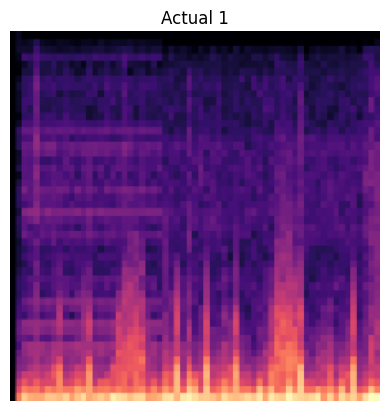

In [381]:
for images, labels in test_ds.take(5):
    labels = labels.numpy()
    i = 0
    # for i in range(1):
        # ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(f'Actual {labels[i]}')


In [382]:
img = images[i].numpy().astype("uint8")

In [383]:
explanation = explainer.explain_instance(
                img,
                model.predict,top_labels=2, hide_color=None,
                num_samples=1000
                )

  0%|          | 0/1000 [00:00<?, ?it/s]

In [384]:
preds = model.predict(test_ds)
preds

array([[0.34022632]], dtype=float32)

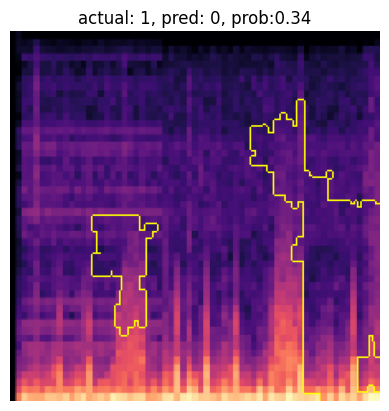

In [385]:
from skimage.segmentation import mark_boundaries
lable = int(np.round(preds[i]))
ind =  explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True, num_features=5, 
                                            hide_rest=False)
# plt.subplot(121)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'actual: {labels[i]}, pred: {lable}, prob:{round(float(preds),2)}')
plt.axis('off')

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)


Text(0.5, 1.0, 'actual: 1, pred: 0, prob:0.34')

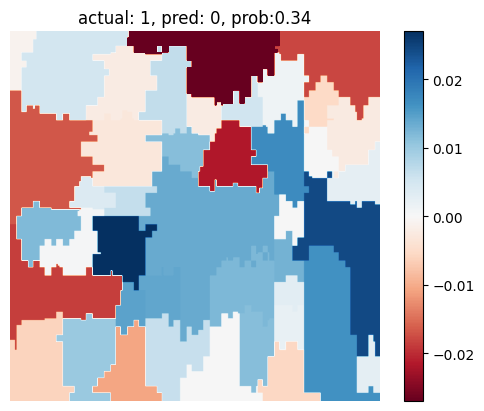

In [386]:
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
# plt.subplot(121)
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
# plt.clim(-0.2, 0.2);
plt.axis('off')
plt.title(f'actual: {labels[i]}, pred: {lable}, prob:{round(float(preds),2)}')


In [387]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_12 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_10  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          